In [1]:
# Get all airlines flight data, 2015 US domestic all carriers
flightInfo = sc.textFile("swift://TrAppnotebooks.spark/114396236_T_T100D_MARKET_ALL_CARRIER.csv");


In [2]:
print "Total number of records:", flightInfo.count()

Total number of records: 105098


In [3]:
print "Each record has the following template\n", flightInfo.first()

Each record has the following template
"PASSENGERS","FREIGHT","MAIL","DISTANCE","UNIQUE_CARRIER","UNIQUE_CARRIER_NAME","CARRIER_NAME","ORIGIN_AIRPORT_ID","ORIGIN","ORIGIN_CITY_NAME","ORIGIN_STATE_ABR","DEST_AIRPORT_ID","DEST","DEST_CITY_NAME","DEST_STATE_ABR","DEST_STATE_NM","YEAR","MONTH","DISTANCE_GROUP",


In [4]:
# parse data into columns, split via "," 
flightParseInfo = flightInfo.map(lambda line : line.split(","))
print flightParseInfo.first()

[u'"PASSENGERS"', u'"FREIGHT"', u'"MAIL"', u'"DISTANCE"', u'"UNIQUE_CARRIER"', u'"UNIQUE_CARRIER_NAME"', u'"CARRIER_NAME"', u'"ORIGIN_AIRPORT_ID"', u'"ORIGIN"', u'"ORIGIN_CITY_NAME"', u'"ORIGIN_STATE_ABR"', u'"DEST_AIRPORT_ID"', u'"DEST"', u'"DEST_CITY_NAME"', u'"DEST_STATE_ABR"', u'"DEST_STATE_NM"', u'"YEAR"', u'"MONTH"', u'"DISTANCE_GROUP"', u'']


In [5]:
# Extract all ORIGIN_CITY info. Each entry is replaced with (cityName, 1) tuple and then reduce it to find the frequency of each origin city 
# Finally the tuples are stored as [frequencyofcityNames, cityName]
originCityInfo = flightParseInfo.map(lambda city: (city[9], 1)).reduceByKey(lambda a,b: a+b).map(lambda entry: (entry[1], entry[0]))

In [6]:
# total number of different point of origins 
print originCityInfo.count()

1103


In [7]:
# print top 25 cities
print "CityName , Num flights"
for pair in originCityInfo.top(25):
    print "%s, %d" % (pair[1],pair[0])

CityName , Num flights
"Chicago, 3330
"Washington, 2380
"Denver, 2378
"Detroit, 2332
"New York, 2313
"Minneapolis, 2288
"Atlanta, 2218
"Houston, 2086
"Dallas/Fort Worth, 1911
"Charlotte, 1663
"Los Angeles, 1655
"Anchorage, 1579
"Phoenix, 1578
"Philadelphia, 1516
"Seattle, 1380
"Newark, 1343
"Las Vegas, 1314
"Boston, 1263
"Salt Lake City, 1214
"Orlando, 1168
"Portland, 1118
"Indianapolis, 1088
"Memphis, 1070
"San Francisco, 1039
"Fort Lauderdale, 1021


In [8]:
# Lets plot the info
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot(tuples, type):
    # Get values/labels into lists and display only the first 20
    values = tuples.map(lambda x: x[0]).collect()[:20]
    labels = tuples.map(lambda x: x[1]).collect()[:20]
    jet = plt.get_cmap('jet')
    #print values
    #plt.barh(range(len(values)), values, color='red')
    if (type == "horizontal"):
        plt.barh(range(len(values)), values, color=jet(np.linspace(0, 1.0, 20)))
        plt.yticks(range(len(values)), labels)
    else:
        plt.bar(range(len(values)), values, color=jet(np.linspace(0, 1.0, 20)))
        plt.xticks(range(len(values)), labels, rotation=90)
    
    plt.show()

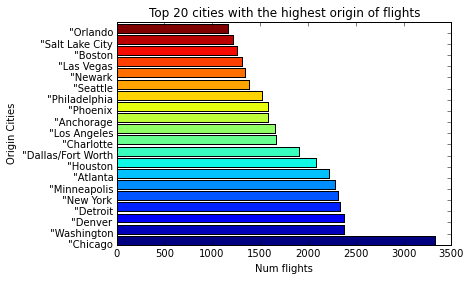

In [9]:
# Lets plot the cities with highest number of starting flights
plt.xlabel('Num flights')
plt.ylabel('Origin Cities')
plt.title('Top 20 cities with the highest origin of flights')
plot(originCityInfo.sortByKey(ascending=False), "horizontal")

In [10]:
# Next lets find the total number of flights run by each carrier and plot
uniqueCarrierInfo = flightParseInfo.map(lambda carrier: (carrier[6], 1)).reduceByKey(lambda a,b: a+b).map(lambda entry: (entry[1], entry[0]))
print uniqueCarrierInfo.count()

121


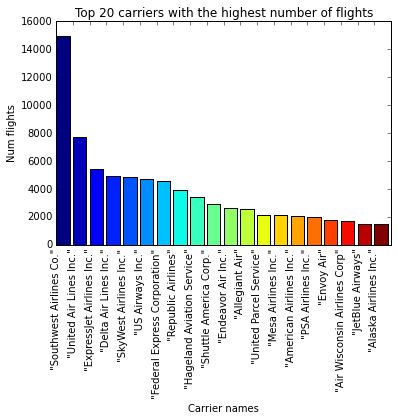

In [11]:
plt.ylabel('Num flights')
plt.xlabel('Carrier names')
plt.title('Top 20 carriers with the highest number of flights')
plot(uniqueCarrierInfo.sortByKey(ascending=False), "vertical")

In [12]:
#find flights carrying only freight
flightsCarryingFreight = flightParseInfo.filter(lambda x: x[0] == "0.00")
print "Total flights carrying only cargo is:", flightsCarryingFreight.count()
print "Total passenger flights is:", flightParseInfo.count() - flightsCarryingFreight.count()

Total flights carrying only cargo is: 17557
Total passenger flights is: 87541


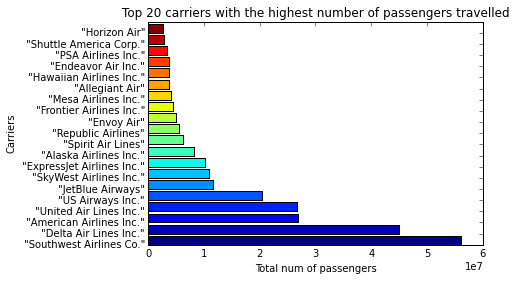

In [13]:
# Check if a value is float
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False
# Find total number of passengers travelled on each airline 
flightsTravelledByEachMonth = flightParseInfo.filter(lambda x:isfloat(x[0])).map(lambda x: (x[6], int(float(x[0])))).reduceByKey(lambda a,b: a+b).map(lambda entry: (entry[1], entry[0]))
plt.ylabel('Carriers')
plt.xlabel('Total num of passengers')
plt.title('Top 20 carriers with the highest number of passengers travelled')
plot(flightsTravelledByEachMonth.sortByKey(ascending=False), "horizontal")


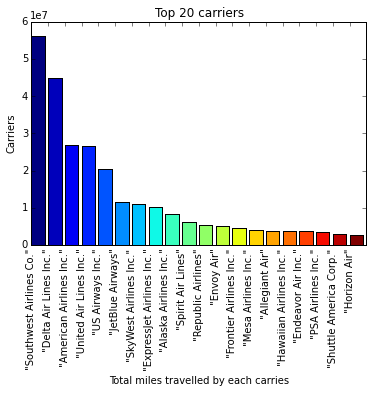

In [14]:
# Lets compare total miles travelled by each carrier
milesTravelledByEachCarrier = flightParseInfo.filter(lambda x:isfloat(x[3])).map(lambda carrier: (carrier[6], int(float(carrier[3])))).reduceByKey(lambda a,b: a+b).map(lambda entry: (entry[1], entry[0]))
plt.ylabel('Carriers')
plt.xlabel('Total miles travelled by each carries')
plt.title('Top 20 carriers')
plot(flightsTravelledByEachMonth.sortByKey(ascending=False), "vertical")

In [15]:
# Next lets play with on time performance of flights
flightOntimeInfo = sc.textFile("swift://TrAppnotebooks.spark/airlines_ontime_records_2014.csv");
print "Total number of records:", flightOntimeInfo.count()
print "Each record has the following template\n", flightOntimeInfo.first()
# parse data into columns, split via "," 
flightOntimeParseInfo = flightOntimeInfo.map(lambda line : line.split(","))

Total number of records: 471950
Each record has the following template
"YEAR","MONTH","CARRIER","FL_NUM","ORIGIN_CITY_NAME","DEST_CITY_NAME","DEP_TIME","DEP_DELAY","DEP_DELAY_NEW","ARR_DELAY","ARR_DELAY_NEW","CANCELLED","CANCELLATION_CODE","DIVERTED","AIR_TIME","FLIGHTS","DISTANCE","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY",


In [16]:
totalDelayByEachCarrierInfo = flightOntimeParseInfo.filter(lambda x:isfloat(x[10])).map(lambda x: (x[2], int(float(x[10])))).reduceByKey(lambda a,b: a+b).map(lambda entry: (entry[1], entry[0]))
print totalDelayByEachCarrierInfo.first()

(139445, u'"FL"')


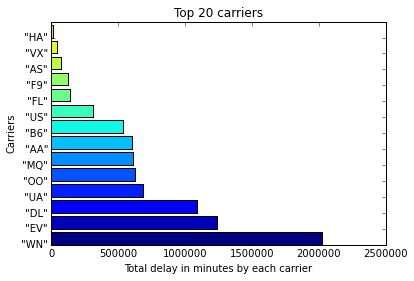

In [17]:
plt.ylabel('Carriers')
plt.xlabel('Total delay in minutes by each carrier')
plt.title('Top 20 carriers')
# Note that the delay computed here includes carrier/weather/airsystem/security/lateaircraft delays
# Turns out "WN" i.e. southwest airlines has the worst delay
plot(totalDelayByEachCarrierInfo.sortByKey(ascending=False), "horizontal")

In [18]:
# lets calculate only the delay caused by carrier and see which airlines delayed the most
carrierDelayOnlyInfo = flightOntimeParseInfo.filter(lambda x:isfloat(x[20])).map(lambda x: (x[2], int(float(x[20])))).reduceByKey(lambda a,b: a+b).map(lambda entry: (entry[1], entry[0]))
print carrierDelayOnlyInfo.first()

(3404, u'"FL"')


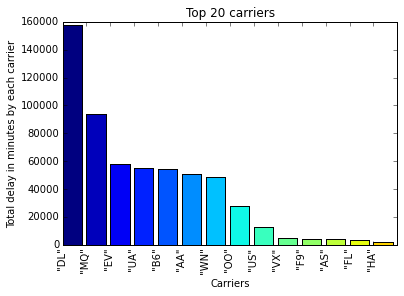

In [19]:
plt.xlabel('Carriers')
plt.ylabel('Total delay in minutes by each carrier')
plt.title('Top 20 carriers')
# It turns out southwest is not as bad considering only the carrier delay "DL" i.e Delta turns out to be the worst carrier delay 
plot(carrierDelayOnlyInfo.sortByKey(ascending=False), "vertical")